# 2025 데이터 크리에이터 캠프

@PHASE: Mission 2

@TEAM: 최후의 인공지능

## Check GPU Availability

In [1]:
!nvidia-smi

Fri Sep  5 01:46:53 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   61C    P0             15W /   78W |       0MiB /   6141MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Set CUDA Device Number
DEVICE_NUM = 0
ADDITIONAL_GPU = 0

from os import environ
environ["CUDA_VISIBLE_DEVICES"] = ",".join([f"{i+DEVICE_NUM}" for i in range(0, ADDITIONAL_GPU+1)])
environ["CUDA_VISIBLE_DEVICES"]

'0'

## Imports

In [3]:
from os import path

from creator_camp.datasets import KompsatDatasetForHeightRegression, DatasetHolder

import torch
from torch import nn
from transformers import Trainer, TrainingArguments
from accelerate import Accelerator, notebook_launcher

from supervision.metrics.mean_average_precision import MeanAveragePrecision
from supervision.detection.core import Detections

#import wandb
import matplotlib.pyplot as plt

In [4]:
if torch.cuda.is_available():
    if ADDITIONAL_GPU:
        device = torch.device("cuda")
    else:
        device = torch.device(f"cuda")  # torch.device(f"cuda:{DEVICE_NUM}")
else:
    device = torch.device("cpu")
    DEVICE_NUM = -1

print(f"INFO: Using device - {device}" + (f":{DEVICE_NUM}" if ADDITIONAL_GPU else ""))

INFO: Using device - cuda


In [5]:
PROJECT_NAME = "Mission_2"
RUN_NAME = "RT-DETR"

# WandB Initialization
environ["WANDB_MODE"] = "disabled"
#wandb.init(project=PROJECT_NAME, name=RUN_NAME, mode="offline")

## Define Dataset

In [6]:
DATA_ROOT = path.join(".", "data")

kompstats = DatasetHolder(train=KompsatDatasetForHeightRegression(root=DATA_ROOT, train=True), valid=KompsatDatasetForHeightRegression(root=DATA_ROOT, train=False))

INFO: Dataset loaded successfully. Number of samples - Train: 8052, Valid: 1006



In [7]:
kompstats.train[0]

(<PIL.Image.Image image mode=RGB size=512x512>,
 {'filename': 'K3A_CHN_20161112052404_0.jpg',
  'size': 63669,
  'regions': [{'polyline': [108, 378, 184, 370],
    'polyline_xywh': [108, 370, 76, 8],
    'chi_height': 76.78},
   {'polyline': [221, 402, 284, 394],
    'polyline_xywh': [221, 394, 63, 8],
    'chi_height': 63.81}],
  'file_attributes': {'img_id': 'K3A_CHN_20161112052404_0',
   'img_height': 512,
   'img_width': 512,
   'img_resolution': '0.55',
   'img_time': '16111205',
   'img_roll_tilt': '28.6724462424',
   'img_pitch_tilt': '1.3777451834',
   'img_provided': '한국항공우주연구원',
   'provided_nm': '한국지능정보사회진흥원'}})

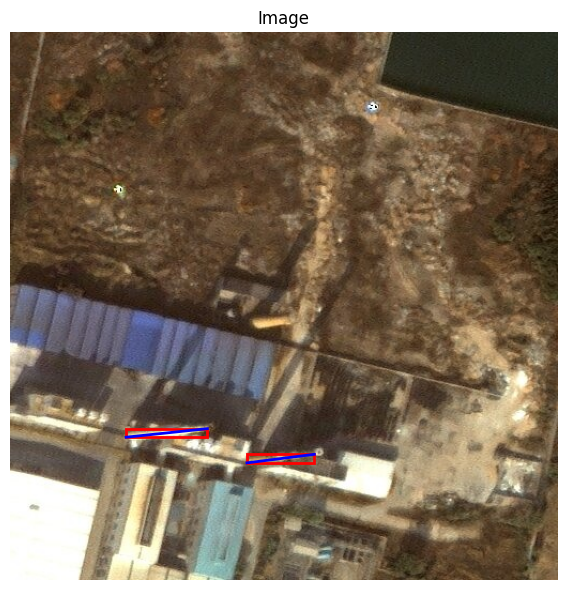

In [8]:
rgb_image, annotation = kompstats.train[0]
fig, axes = plt.subplots(1, 1, figsize=(6, 6))

axes.imshow(rgb_image)
axes.set_title('Image')
axes.axis('off')

for region in annotation['regions']:
    x1, y1, w, h = region['polyline_xywh']
    rect = plt.Rectangle((x1, y1), w, h, fill=False, edgecolor='red', linewidth=2)
    axes.add_patch(rect)

    polyline = region['polyline']
    xs = [polyline[0], polyline[2]]
    ys = [polyline[1], polyline[3]]
    axes.plot(xs, ys, color='blue', linewidth=2)

plt.tight_layout()
plt.show()

## DataLoader

In [9]:
# Set Batch Size
BATCH_SIZE = 4, 8, 8, 4  # Local
#BATCH_SIZE = 32, 64, 64, 32  # A100

# Dataset Configs
NUM_CLASSES = 1

print(f"INFO: Set batch size - Train: {BATCH_SIZE[0]}, Valid: {BATCH_SIZE[1]}, Test: {BATCH_SIZE[2]}")

INFO: Set batch size - Train: 4, Valid: 8, Test: 8


In [10]:
ORIGIN_SIZE = 512

def collate_fn(batch, preprocessor):
    images = [item[0] for item in batch]
    targets = []
    heights = []

    for annotations in [item[1] for item in batch]:
        ann_list = []
        height_list = []
        for reg in annotations['regions']:
            _, _, w, h = reg['polyline_xywh']
            ann_list.append(dict(
                bbox=reg['polyline_xywh'],
                category_id=1,
                area=w * h,
                iscrowd=0
            ))
            height_list.append(min(reg['chi_height'] / ORIGIN_SIZE, 1.0))
        targets.append(dict(image_id=len(targets), annotations=ann_list))
        heights.append(height_list)

    processed = preprocessor(images=images, annotations=targets, return_tensors="pt")  # normalizes bbox to [0, 1]

    for label, h in zip(processed['labels'], heights):
        h = torch.tensor(h, dtype=torch.float32).view(-1, 1)
        assert label['boxes'].shape[0] == h.shape[0], f"label['boxes'].shape[0] = {label['boxes'].shape[0]}, h.shape[0] = {h.shape[0]}, original data = {[item[1] for item in batch]}"
        label['boxes'] = torch.cat([label['boxes'], h], dim=1)  # check if preprocessor removed any bbox
    return processed

## Load Model

In [11]:
from transformers import RTDetrImageProcessorFast, RTDetrConfig
from transformers.image_utils import AnnotationFormat
from creator_camp.models.rt_detr import RTDetrForObjectDetectionWithHeight

🚨 Something went wrong trying to find the model name in the path: C:\Users\BREW\Downloads\K-ICT\K-ICT_DataCreatorCamp_2025\src\creator_camp\models\rt_detr\custom_rt_detr.py
🚨 Config not found for model. You can manually add it to HARDCODED_CONFIG_FOR_MODELS in utils/auto_docstring.py
🚨 Something went wrong trying to find the model name in the path: C:\Users\BREW\Downloads\K-ICT\K-ICT_DataCreatorCamp_2025\src\creator_camp\models\rt_detr\custom_rt_detr.py
🚨 Something went wrong trying to find the model name in the path: C:\Users\BREW\Downloads\K-ICT\K-ICT_DataCreatorCamp_2025\src\creator_camp\models\rt_detr\custom_rt_detr.py
🚨 Config not found for model. You can manually add it to HARDCODED_CONFIG_FOR_MODELS in utils/auto_docstring.py
🚨 Something went wrong trying to find the model name in the path: C:\Users\BREW\Downloads\K-ICT\K-ICT_DataCreatorCamp_2025\src\creator_camp\models\rt_detr\custom_rt_detr.py
🚨 Something went wrong trying to find the model name in the path: C:\Users\BREW\Down

In [12]:
reference_model_id = "PekingU/rtdetr_r50vd"

# Load the reference model configuration
reference_config = RTDetrConfig.from_pretrained(reference_model_id, dtype=torch.float32, return_dict=True)
reference_config.num_labels = NUM_CLASSES + 1

# Set the image size and preprocessor size
reference_config.image_size = 640

# Load the reference model image processor
reference_preprocessor = RTDetrImageProcessorFast.from_pretrained(reference_model_id)
reference_preprocessor.format = AnnotationFormat.COCO_DETECTION  # COCO Format / Detection BBOX Format
reference_preprocessor.size = {"height": 640, "width": 640}
reference_preprocessor.do_resize = True

In [13]:
collate_fn([kompstats.train[0], kompstats.train[1]], reference_preprocessor)

{'pixel_values': tensor([[[[0.3020, 0.2863, 0.2902,  ..., 0.1686, 0.1686, 0.1647],
          [0.2863, 0.2824, 0.2980,  ..., 0.1686, 0.1647, 0.1569],
          [0.2902, 0.2824, 0.3020,  ..., 0.1765, 0.1725, 0.1569],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 0.5333, 0.5255, 0.5137],
          [1.0000, 1.0000, 1.0000,  ..., 0.5294, 0.5255, 0.5216],
          [1.0000, 1.0000, 1.0000,  ..., 0.5412, 0.5412, 0.5412]],

         [[0.2157, 0.2000, 0.2039,  ..., 0.1922, 0.1922, 0.1882],
          [0.2000, 0.1961, 0.2118,  ..., 0.1922, 0.1882, 0.1804],
          [0.2039, 0.1961, 0.2157,  ..., 0.2000, 0.1961, 0.1804],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 0.4157, 0.4118, 0.4000],
          [1.0000, 1.0000, 1.0000,  ..., 0.4118, 0.4118, 0.4078],
          [1.0000, 1.0000, 1.0000,  ..., 0.4275, 0.4275, 0.4275]],

         [[0.1333, 0.1176, 0.1216,  ..., 0.1451, 0.1451, 0.1412],
          [0.1176, 0.1137, 0.1294,  ..., 0.1451, 0.1412, 0.1333],
          [0.1216, 0.1137

In [14]:
model = RTDetrForObjectDetectionWithHeight.from_pretrained(reference_model_id, config=reference_config, torch_dtype=torch.float32, ignore_mismatched_sizes=True)
model.to(device)

Some weights of RTDetrForObjectDetection were not initialized from the model checkpoint at PekingU/rtdetr_r50vd and are newly initialized because the shapes did not match:
- model.decoder.bbox_embed.0.layers.2.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([5]) in the model instantiated
- model.decoder.bbox_embed.0.layers.2.weight: found shape torch.Size([4, 256]) in the checkpoint and torch.Size([5, 256]) in the model instantiated
- model.decoder.bbox_embed.1.layers.2.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([5]) in the model instantiated
- model.decoder.bbox_embed.1.layers.2.weight: found shape torch.Size([4, 256]) in the checkpoint and torch.Size([5, 256]) in the model instantiated
- model.decoder.bbox_embed.2.layers.2.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([5]) in the model instantiated
- model.decoder.bbox_embed.2.layers.2.weight: found shape torch.Size([4, 256]) in the checkpoint and torch.Size([5, 256]) in

RTDetrForObjectDetection(
  (model): RTDetrModel(
    (backbone): RTDetrConvEncoder(
      (model): RTDetrResNetBackbone(
        (embedder): RTDetrResNetEmbeddings(
          (embedder): Sequential(
            (0): RTDetrResNetConvLayer(
              (convolution): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
              (normalization): RTDetrFrozenBatchNorm2d()
              (activation): ReLU()
            )
            (1): RTDetrResNetConvLayer(
              (convolution): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (normalization): RTDetrFrozenBatchNorm2d()
              (activation): ReLU()
            )
            (2): RTDetrResNetConvLayer(
              (convolution): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (normalization): RTDetrFrozenBatchNorm2d()
              (activation): ReLU()
            )
          )
          (pooler): MaxPool2d(

In [15]:
from transformers.image_transforms import center_to_corners_format

def post_process_object_detection(
    self,
    outputs,
    threshold: float = 0.5,
    target_sizes: list[tuple] = None,
    use_focal_loss: bool = True,
):
    out_logits, out_bbox = outputs.logits, outputs.pred_boxes
    # convert from relative cxcywh to absolute xyxy
    boxes, heights = center_to_corners_format(out_bbox[:, :, :4]), out_bbox[:, :, 4:]
    if target_sizes is not None:
        if len(out_logits) != len(target_sizes):
            raise ValueError(
                "Make sure that you pass in as many target sizes as the batch dimension of the logits"
            )
        if isinstance(target_sizes, list):
            img_h, img_w = torch.as_tensor(target_sizes).unbind(1)
        else:
            img_h, img_w = target_sizes.unbind(1)
        scale_fct = torch.stack([img_w, img_h, img_w, img_h], dim=1).to(boxes.device)
        boxes = boxes * scale_fct[:, None, :]
        height_scale = img_h.unsqueeze(1).to(heights.device)
        heights = heights * height_scale[:, None, :]

    num_top_queries = out_logits.shape[1]
    num_classes = out_logits.shape[2]

    if use_focal_loss:
        scores = torch.nn.functional.sigmoid(out_logits)
        scores, index = torch.topk(scores.flatten(1), num_top_queries, axis=-1)
        labels = index % num_classes
        index = index // num_classes
        boxes = boxes.gather(dim=1, index=index.unsqueeze(-1).repeat(1, 1, boxes.shape[-1]))
        heights = heights.gather(dim=1, index=index.unsqueeze(-1).repeat(1, 1, heights.shape[-1]))
    else:
        scores = torch.nn.functional.softmax(out_logits)[:, :, :-1]
        scores, labels = scores.max(dim=-1)
        if scores.shape[1] > num_top_queries:
            scores, index = torch.topk(scores, num_top_queries, dim=-1)
            labels = torch.gather(labels, dim=1, index=index)
            boxes = torch.gather(boxes, dim=1, index=index.unsqueeze(-1).tile(1, 1, boxes.shape[-1]))
            heights = heights.gather(heights, dim=1, index=index.unsqueeze(-1).tile(1, 1, heights.shape[-1]))

    results = []
    for score, label, box, height in zip(scores, labels, boxes, heights):
        mask = score > threshold
        results.append(
            {
                "scores": score[mask],
                "labels": label[mask],
                "boxes": box[mask],
                "heights": height[mask]
            }
        )

    return results

RTDetrImageProcessorFast.post_process_object_detection = post_process_object_detection

In [16]:
from transformers.trainer_utils import EvalPrediction
from torchvision.ops import box_convert
from dataclasses import dataclass


@dataclass
class ModelOutput:
    logits: torch.Tensor
    pred_boxes: torch.Tensor


def map_compute_metrics(preprocessor=reference_preprocessor, threshold=0.0):
    map_metric = MeanAveragePrecision()
    height_metric = []
    mse_loss = torch.nn.functional.mse_loss
    post_process = preprocessor.post_process_object_detection

    def calc(eval_pred: EvalPrediction, compute_result=False):
        nonlocal map_metric

        if compute_result:
            m_ap = map_metric.compute()
            map_metric.reset()
            height_rmse = []
            for preds, labels in zip(*height_metric):
                for label in labels:
                    rmse = torch.sqrt(mse_loss(preds, label.expand(preds.shape[0], 1)))
                    height_rmse.append(torch.min(rmse))
            height_metric.clear()

            return {
                "RMSE": torch.mean(torch.stack(height_rmse)).item(),
                "mAP@0.50:0.95": m_ap.map50_95,
                "mAP@0.50": m_ap.map50,
                "mAP@0.75": m_ap.map75
            }
        else:
            preds = ModelOutput(*eval_pred.predictions[1:3])
            labels = eval_pred.label_ids
            sizes = [label['orig_size'].cpu().tolist() for label in labels]

            results = post_process(preds, target_sizes=sizes, threshold=threshold)
            predictions = [Detections.from_transformers(result) for result in results]
            targets = [Detections(
                xyxy=box_convert(label['boxes'][:, :4], "cxcywh", "xyxy").detach().cpu().numpy(),
                class_id=label['class_labels'].detach().cpu().numpy(),
            ) for label in labels]

            map_metric.update(predictions=predictions, targets=targets)

            height_preds = [result['heights'] for result in results]
            height_targets = [label['boxes'][:, 4:] for label in labels]

            if len(height_metric) != 2:
                height_metric.extend([[], []])

            height_metric[0].extend(height_preds)
            height_metric[1].extend(height_targets)
            return {}

    return calc, map_metric, height_metric

## Train

In [17]:
# Set Epoch Count & Learning Rate
EPOCHS = 30
REAL_BATCH = BATCH_SIZE[-1]
LEARNING_RATE = 1e-4

training_args = TrainingArguments(
    learning_rate=LEARNING_RATE,
    lr_scheduler_type="cosine",
    warmup_ratio=0.1,
    weight_decay=0.1,
    max_grad_norm=0.5,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE[0],
    per_device_eval_batch_size=BATCH_SIZE[1],
    gradient_accumulation_steps=REAL_BATCH//BATCH_SIZE[0],
    eval_accumulation_steps=BATCH_SIZE[1],
    batch_eval_metrics=True,
    remove_unused_columns=False,
    optim="adamw_torch",
    eval_strategy="steps",
    save_strategy="steps",
    logging_strategy="steps",
    eval_steps=100,
    save_steps=100,
    logging_steps=100,
    save_total_limit=100,
    load_best_model_at_end=True,
    #metric_for_best_model="mAP@0.50",
    #greater_is_better=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    #report_to="wandb",
    output_dir="./results/"+RUN_NAME,
    logging_dir="./logs/"+RUN_NAME,
    #run_name=RUN_NAME,
    bf16=True,
)

In [18]:
from functools import partial

compute_metrics, compute_results, height_metric = map_compute_metrics(preprocessor=reference_preprocessor)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=kompstats.train,
    eval_dataset=kompstats.valid,
    data_collator=partial(collate_fn, preprocessor=reference_preprocessor),
    compute_metrics=compute_metrics,
    #callbacks=[EarlyStoppingCallback(early_stopping_patience=30)]
)

In [19]:
def start_train():
    accelerator = Accelerator()
    compute_results.reset()
    height_metric.clear()
    trainer.train()

In [ ]:
if ADDITIONAL_GPU:
    notebook_launcher(start_train, args=(), num_processes=ADDITIONAL_GPU)
else:
    start_train()

Step,Training Loss,Validation Loss,Rmse,Map@0.50:0.95,Map@0.50,Map@0.75
100,717.959000,593.287292,28.750666,0.000000,0.000000,0.000000
200,418.282200,243.920059,37.354282,0.000000,0.000000,0.000000


In [ ]:
%debug

In [ ]:
preds, targets = height_metric

In [ ]:
len(preds)

In [ ]:
len(targets)

## Evaluate

In [ ]:
trainer.evaluate()

In [ ]:
checkpoint = 31100

In [ ]:
try:
    model = RTDetrForObjectDetection.from_pretrained(f"{training_args.output_dir}/checkpoint-{checkpoint}/", torch_dtype=torch.float32, return_dict=True, local_files_only=True)
    model.to(device)
except Exception:
    pass